##SNACS 2021 Project<br/> Community Aware Detection of Anomalies using Leiden Algorithm <br/> by Noel Rohan Vasanth and Lucan van Rooij

####Setup

In [ ]:
# acquiring the dataset from drive, installing libraries
!unzip '/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/Amazon.zip'
!pip install infomap
!pip install leidenalg
!pip install cdlib

Archive:  /content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/Amazon.zip
  inflating: Amazon.mat              
     |████████████████████████████████| 292 kB 14.6 MB/s 
  Created wheel for infomap: filename=infomap-1.9.0-cp37-cp37m-linux_x86_64.whl size=5867332 sha256=b5cce39cb0f5545c68fa86f0dc4dceccf3cfc038d7a44accb093d9fa3005edb7
  Stored in directory: /root/.cache/pip/wheels/88/7d/77/d5f814617bfea19465faad2bae4d95862d9faa83b707088747
Successfully built infomap
     |████████████████████████████████| 1.4 MB 16.7 MB/s 
     |████████████████████████████████| 3.2 MB 38.3 MB/s 
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9070 sha256=210c2caf42dfcf59afd31f17e3fe638e0a5d4091865511c99873c80f13360d26
  Stored in directory: /root/.cache/pip/wheels/15/86/ef/b8bcdfbcb1c489771ad256c7cd1eb4971cdb7f3f670938b798
Successfully built python-igraph
     |████████████████████████████████| 227 kB 14.9 MB/s 
     |████████████████████████████████| 14.2 MB 49.3 M

In [ ]:
# importing libraries
import pandas as pd
import networkx as nx
import numpy as np
import scipy.io
from math import sqrt
import random
import community.community_louvain as community_louvain
import time
import infomap
import leidenalg
import igraph as ig
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import glob
import time

In [ ]:
amazon_mat = scipy.io.loadmat('/content/Amazon.mat')
amazon_mat

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Aug 19 20:20:49 2020',
 '__version__': '1.0',
 'features': <11944x25 sparse matrix of type '<class 'numpy.float64'>'
 	with 174488 stored elements in Compressed Sparse Column format>,
 'homo': <11944x11944 sparse matrix of type '<class 'numpy.float64'>'
 	with 8796784 stored elements in Compressed Sparse Column format>,
 'label': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'net_upu': <11944x11944 sparse matrix of type '<class 'numpy.float64'>'
 	with 351216 stored elements in Compressed Sparse Column format>,
 'net_usu': <11944x11944 sparse matrix of type '<class 'numpy.float64'>'
 	with 7132958 stored elements in Compressed Sparse Column format>,
 'net_uvu': <11944x11944 sparse matrix of type '<class 'numpy.float64'>'
 	with 2073474 stored elements in Compressed Sparse Column format>}

In [ ]:
dense_amazon_mat = amazon_mat['net_upu'].todense()
amazon_network = nx.from_numpy_matrix(dense_amazon_mat)
print(amazon_network.number_of_edges())
print(amazon_network.number_of_nodes())
anomalous_nodes_amazon = np.where(amazon_mat['label'] == 1)[1]

175608
11944


####CADA function - with Leiden

In [ ]:
class cada():
	def __init__(self, graph, algorithm='louvain', resolution=0.1):
		
		# First do community detection
		if algorithm == 'louvain':
			partition = community_louvain.best_partition(graph, resolution=resolution)
		elif algorithm == 'louvain2':
			optimiser = leidenalg.Optimiser()
			ig_graph = ig.Graph.from_networkx(graph)
			p = leidenalg.ModularityVertexPartition(ig_graph)
			while optimiser.move_nodes(p) > 0:
						p = p.aggregate_partition()
			partition = {node:mem for node, mem in zip(amazon_network.nodes, p.membership)}
		elif algorithm == 'leiden':
			ig_graph = ig.Graph.from_networkx(graph)
			p = leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition, n_iterations=-1, seed=2)
			partition = {node:mem for node, mem in zip(amazon_network.nodes, p.membership)}
		elif algorithm == 'leiden2':
			ig_graph = ig.Graph.from_networkx(graph)
			p = leidenalg.find_partition(ig_graph, leidenalg.CPMVertexPartition, resolution_parameter = resolution, n_iterations=-1)
			partition = {node:mem for node, mem in zip(amazon_network.nodes, p.membership)}
		else:
			partition = self.run_infomap(graph)
		
		communities = set()
		for node in graph.nodes():
			if node in partition:
				communities.add(partition[node])

		anom_score = {}

		# Compute anomaly score for each node
		for node in graph.nodes():
			comms = {}
			for neighbor in graph.neighbors(node):
				if neighbor != node:
					try:
						if partition[neighbor] not in comms:
							comms[partition[neighbor]] = 0
						comms[partition[neighbor]] += 1
					except KeyError:
						continue

			if len(comms) > 0:
				# The number of communities it is connected to. 
				comms = np.array(list(comms.values()))
				# print('nr communities connected', comms)
				max_com = np.max(comms)
				# print('Maxcommunity', max_com)
				comms = comms / max_com
				# print('Communities normalized', comms)
				anom_score[node] = np.sum(comms)		
				# print('Anomaly score., ', anom_score[node])
			else:
				anom_score[node] = 0
		
		self.anomaly_scores = sorted(anom_score.items(), key=lambda x: x[1], reverse = True)[::-1]


	def run_infomap(self, graph):
		"""
		Runs Infomap with infomap package 
		"""
		infomapSimple = infomap.Infomap("--two-level --silent")
		network = infomapSimple.network
		
		for e in graph.edges():
			network.addLink(e[0], e[1])

		partition = {}
		infomapSimple.run();
		for node in infomapSimple.iterTree():
			if node.isLeaf():
				partition[node.physicalId] = node.moduleIndex()

		return partition

	def get_anomaly_scores(self, nr_anomalies=None):
		"""
		Returns tuple (node, anomaly_score) for either nr_anomalies or all
		"""
		if nr_anomalies:
			return self.anomaly_scores[:nr_anomalies]
		else:
			return self.anomaly_scores 

	def get_top_anomalies(self, nr_anomalies=100):
		"""
		Returns highest scoring anomalies
		"""					
		anomalies = []
		for anomaly in self.anomaly_scores[:nr_anomalies]:
			anomalies.append(anomaly[0])

		return anomalies

	def get_anomalies_threshold(self, threshold):
		"""
		Returns anomalies that are above a certain threshold.
		"""
		anomalies = []

		for anomaly in self.anomaly_scores:
			if anomaly[1] > threshold:
				anomalies.append(anomaly[0])
			else:
				break

		return anomalies

def evaluate_performance(predicted_anomalies, ground_truth):
    correctly_predicted = []
    for node in predicted_anomalies:
        if node in ground_truth:
            correctly_predicted.append(node)
    tpr = len(correctly_predicted)/len(ground_truth)
    print(len(correctly_predicted))
    return tpr


#### Time trials of CADA per algorithm

In [ ]:
%%time
c = cada(amazon_network, algorithm='louvain', resolution=1)

top_anomalies = c.get_top_anomalies(nr_anomalies=len(anomalous_nodes_amazon))
# print(top_anomalies, anomalous_nodes_amazon)
print(evaluate_performance(top_anomalies, anomalous_nodes_amazon))

41
0.049939098660170524
CPU times: user 9.28 s, sys: 62.2 ms, total: 9.34 s
Wall time: 9.36 s


In [ ]:
%%time
c = cada(amazon_network, algorithm='leiden', resolution=1)

top_anomalies = c.get_top_anomalies(nr_anomalies=len(anomalous_nodes_amazon))
# print(len(top_anomalies), len(c.get_anomaly_scores()), len(anomalous_nodes_amazon))
print(evaluate_performance(top_anomalies, anomalous_nodes_amazon))

41
0.049939098660170524
CPU times: user 3.06 s, sys: 7.88 ms, total: 3.06 s
Wall time: 3.07 s


In [ ]:
%%time
c = cada(amazon_network, algorithm='leiden2', resolution=1)

top_anomalies = c.get_top_anomalies(nr_anomalies=len(anomalous_nodes_amazon))
# print(top_anomalies, anomalous_nodes_amazon)
print(evaluate_performance(top_anomalies, anomalous_nodes_amazon))

83
0.10109622411693057
CPU times: user 937 ms, sys: 8.98 ms, total: 946 ms
Wall time: 955 ms


In [ ]:
%%time
c = cada(amazon_network, algorithm='infomap', resolution=1)

top_anomalies = c.get_top_anomalies(nr_anomalies=len(anomalous_nodes_amazon))
# print(top_anomalies, anomalous_nodes_amazon)
print(evaluate_performance(top_anomalies, anomalous_nodes_amazon))

128
0.1559074299634592
CPU times: user 1.41 s, sys: 12 ms, total: 1.42 s
Wall time: 1.42 s


#### LFR benchmark dataset


In [ ]:
dense_amazon_mat = amazon_mat['net_upu'].todense()
# amazon_network = nx.from_numpy_matrix(dense_amazon_mat)
def generate_LFR_graph(n = 10000, mu = 0.4):
    tau1 = 3
    tau2 = 2
    max_degree = int(pow(n,0.5))
    max_community = int(0.1 * n)
    average_degree = int(2*pow(n,1.15)/n)
    G = nx.generators.community.LFR_benchmark_graph(
        n,
        tau1,
        tau2,
        mu,
        average_degree=average_degree,
        max_community=max_community,
        max_degree=max_degree,
        seed=11,
    )
    return G

n=10000
LFR_network = generate_LFR_graph(n, 0.4)

def inject_random_anomalies(graph,k, k_max, t1):
    graph = graph.copy()
    n = graph.number_of_nodes()
    anomalous_node_ids = np.arange(n, int(n+(n/100)))
    for index, node_id in enumerate(anomalous_node_ids):
        while True:
            x = nx.utils.random_sequence.zipf_rv(alpha=t1)
            if x > k and x < k_max:
                break
        graph.add_node(node_id)
        for edge in range(0,x):
            graph.add_edge(node_id,random.randint(0,n))
    unanomalous_nodes = np.arange(0,graph.number_of_nodes()-len(anomalous_node_ids))
    zeros = np.zeros(len(unanomalous_nodes))
    ones = np.ones(len(anomalous_node_ids))
    labels = np.append(zeros, ones)
    return graph, labels

def inject_replaced_anomalies(graph, k):
    graph = graph.copy()
    n = graph.number_of_nodes()
    unanomalous_nodes = np.arange(0,n)
    anomalous_nodes = np.arange(n,int(n+n/100))
    nodes_with_degree_less_2k = []
    for node in graph.nodes():
        if graph.degree[node] < 2*k:
            nodes_with_degree_less_2k.append(node)
    
    for count, anomalous_node in enumerate(anomalous_nodes):
        graph.add_node(anomalous_node)
        x = random.sample(nodes_with_degree_less_2k, random.randint(2,21))
        for node in x:
            if node not in graph:
                continue
            edges = graph.edges([node])
            edges = list(edges)
            for edge in edges:
                graph.add_edge(anomalous_node, edge[1])
            graph.remove_node(node)
    len_zeros = graph.number_of_nodes() - len(anomalous_nodes)
    zeros = np.zeros(len_zeros)
    ones = np.ones(len(anomalous_nodes))
    labels = np.append(zeros, ones)
    return graph, labels

# injecting anomalies - random
LFR_network_random_anomalies, LFR_labels_random = inject_random_anomalies(
    LFR_network,
    k = int(2*pow(n,1.15)/n),
    k_max = int(pow(n,0.5)),
    t1 = 3)


# injecting anomalies - replaced
LFR_network_replaced_anomalies, LFR_labels_replaced = inject_replaced_anomalies(
    LFR_network,
    k = int(2*pow(n,1.15)/n))

print(f'Replaced anomalies: {LFR_network_replaced_anomalies.number_of_nodes()}, {len(LFR_labels_replaced)}')
print(f'Random anomalies : {LFR_network_random_anomalies.number_of_nodes()}, {len(LFR_labels_random)}')

# nx.write_edgelist(LFR_network, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_network.csv')

Replaced anomalies: 8942, 8942
Random anomalies : 10100, 10100


####ROC plots

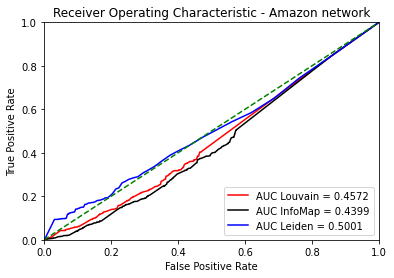

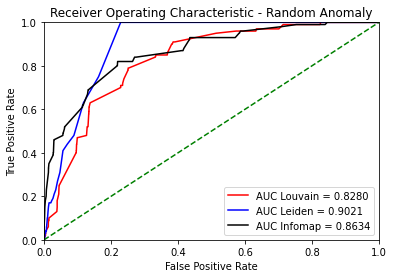

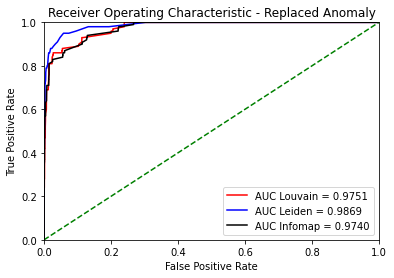

In [ ]:
cada_louvain = cada(amazon_network, algorithm = 'louvain', resolution=1)
cada_infomap = cada(amazon_network, algorithm='infomap')
cada_leiden = cada(amazon_network, algorithm = 'leiden2', resolution=1)

cada_louvain_LFR_random = cada(LFR_network_random_anomalies, algorithm = 'louvain', resolution=1)
# cada_louvain2_LFR_random = cada(LFR_network_random_anomalies, algorithm = 'louvain2')
# cada_leiden_LFR_random = cada(LFR_network_random_anomalies, algorithm = 'leiden')
cada_leiden2_LFR_random = cada(LFR_network_random_anomalies, algorithm = 'leiden2', resolution=1)
cada_infomap_LFR_random = cada(LFR_network_random_anomalies, algorithm = 'infomap')


cada_louvain_LFR_replaced = cada(LFR_network_replaced_anomalies, algorithm = 'louvain')
# cada_louvain2_LFR_replaced = cada(LFR_network_replaced_anomalies, algorithm = 'louvain2')
# cada_leiden_LFR_replaced = cada(LFR_network_replaced_anomalies, algorithm = 'leiden')
cada_leiden2_LFR_replaced = cada(LFR_network_replaced_anomalies, algorithm = 'leiden2', resolution=1)
cada_infomap_LFR_replaced = cada(LFR_network_replaced_anomalies, algorithm = 'infomap')

# #Get anomaly scores for each community detection algorithm
anomaly_scores_cada_louvain = dict(cada_louvain.get_anomaly_scores())
anomaly_scores_cada_leiden = dict(cada_leiden.get_anomaly_scores())
anomaly_scores_cada_infomap = dict(cada_infomap.get_anomaly_scores())

anomaly_scores_cada_louvain_LFR_random = dict(cada_louvain_LFR_random.get_anomaly_scores())
# anomaly_scores_cada_louvain2_LFR_random = dict(cada_louvain2_LFR_random.get_anomaly_scores())
# anomaly_scores_cada_leiden_LFR_random = dict(cada_leiden_LFR_random.get_anomaly_scores())
anomaly_scores_cada_leiden2_LFR_random = dict(cada_leiden2_LFR_random.get_anomaly_scores())
anomaly_scores_cada_infomap_LFR_random = dict(cada_infomap_LFR_random.get_anomaly_scores())

anomaly_scores_cada_louvain_LFR_replaced = dict(cada_louvain_LFR_replaced.get_anomaly_scores())
# anomaly_scores_cada_louvain2_LFR_replaced = dict(cada_louvain2_LFR_replaced.get_anomaly_scores())
# anomaly_scores_cada_leiden_LFR_replaced = dict(cada_leiden_LFR_replaced.get_anomaly_scores())
anomaly_scores_cada_leiden2_LFR_replaced = dict(cada_leiden2_LFR_replaced.get_anomaly_scores())
anomaly_scores_cada_infomap_LFR_replaced = dict(cada_infomap_LFR_replaced.get_anomaly_scores())

# #Sort the scores based on node id so order matches with label column
sorted_anomaly_scores_louvain = [anomaly_scores_cada_louvain[key] for key in sorted(anomaly_scores_cada_louvain)]
sorted_anomaly_scores_leiden = [anomaly_scores_cada_leiden[key] for key in sorted(anomaly_scores_cada_leiden)]
sorted_anomaly_scores_infomap = [anomaly_scores_cada_infomap[key] for key in sorted(anomaly_scores_cada_infomap)]

sorted_anomaly_scores_louvain_LFR_random = [anomaly_scores_cada_louvain_LFR_random[key] for key in sorted(anomaly_scores_cada_louvain_LFR_random)]
# sorted_anomaly_scores_louvain2_LFR_random = [anomaly_scores_cada_louvain2_LFR_random[key] for key in sorted(anomaly_scores_cada_louvain2_LFR_random)]
# sorted_anomaly_scores_leiden_LFR_random = [anomaly_scores_cada_leiden_LFR_random[key] for key in sorted(anomaly_scores_cada_leiden_LFR_random)]
sorted_anomaly_scores_leiden2_LFR_random = [anomaly_scores_cada_leiden2_LFR_random[key] for key in sorted(anomaly_scores_cada_leiden2_LFR_random)]
sorted_anomaly_scores_infomap_LFR_random = [anomaly_scores_cada_infomap_LFR_random[key] for key in sorted(anomaly_scores_cada_infomap_LFR_random)]

sorted_anomaly_scores_louvain_LFR_replaced = [anomaly_scores_cada_louvain_LFR_replaced[key] for key in sorted(anomaly_scores_cada_louvain_LFR_replaced)]
# sorted_anomaly_scores_louvain2_LFR_replaced = [anomaly_scores_cada_louvain2_LFR_replaced[key] for key in sorted(anomaly_scores_cada_louvain2_LFR_replaced)]
# sorted_anomaly_scores_leiden_LFR_replaced = [anomaly_scores_cada_leiden_LFR_replaced[key] for key in sorted(anomaly_scores_cada_leiden_LFR_replaced)]
sorted_anomaly_scores_leiden2_LFR_replaced = [anomaly_scores_cada_leiden2_LFR_replaced[key] for key in sorted(anomaly_scores_cada_leiden2_LFR_replaced)]
sorted_anomaly_scores_infomap_LFR_replaced = [anomaly_scores_cada_infomap_LFR_replaced[key] for key in sorted(anomaly_scores_cada_infomap_LFR_replaced)]

# #Plot ROC curves
fpr_louvain, tpr_louvain, threshold_louvain = metrics.roc_curve(amazon_mat['label'].squeeze(), sorted_anomaly_scores_louvain)
roc_auc_louvain = metrics.auc(fpr_louvain, tpr_louvain)
fpr_leiden, tpr_leiden, threshold_leiden = metrics.roc_curve(amazon_mat['label'].squeeze(), sorted_anomaly_scores_leiden)
roc_auc_leiden = metrics.auc(fpr_leiden, tpr_leiden)
fpr_infomap, tpr_infomap, threshold_infomap = metrics.roc_curve(amazon_mat['label'].squeeze(), sorted_anomaly_scores_infomap)
roc_auc_infomap = metrics.auc(fpr_infomap, tpr_infomap)

fpr_louvain_LFR_random, tpr_louvain_LFR_random, threshold_louvain_LFR_random = metrics.roc_curve(LFR_labels_random, sorted_anomaly_scores_louvain_LFR_random)
roc_auc_louvain_LFR_random = metrics.auc(fpr_louvain_LFR_random, tpr_louvain_LFR_random)
# fpr_louvain2_LFR_random, tpr_louvain2_LFR_random, threshold_louvain2_LFR_random = metrics.roc_curve(LFR_labels_random, sorted_anomaly_scores_louvain2_LFR_random)
# roc_auc_louvain2_LFR_random = metrics.auc(fpr_louvain2_LFR_random, tpr_louvain2_LFR_random)
# fpr_leiden_LFR_random, tpr_leiden_LFR_random, threshold_leiden_LFR_random = metrics.roc_curve(LFR_labels_random, sorted_anomaly_scores_leiden_LFR_random)
# roc_auc_leiden_LFR_random = metrics.auc(fpr_leiden_LFR_random, tpr_leiden_LFR_random)
fpr_leiden2_LFR_random, tpr_leiden2_LFR_random, threshold_leiden2_LFR_random = metrics.roc_curve(LFR_labels_random, sorted_anomaly_scores_leiden2_LFR_random)
roc_auc_leiden2_LFR_random = metrics.auc(fpr_leiden2_LFR_random, tpr_leiden2_LFR_random)
fpr_infomap_LFR_random, tpr_infomap_LFR_random, threshold_infomap_LFR_random = metrics.roc_curve(LFR_labels_random, sorted_anomaly_scores_infomap_LFR_random)
roc_auc_infomap_LFR_random = metrics.auc(fpr_infomap_LFR_random, tpr_infomap_LFR_random)

fpr_louvain_LFR_replaced, tpr_louvain_LFR_replaced, threshold_louvain_LFR_replaced = metrics.roc_curve(LFR_labels_replaced, sorted_anomaly_scores_louvain_LFR_replaced)
roc_auc_louvain_LFR_replaced = metrics.auc(fpr_louvain_LFR_replaced, tpr_louvain_LFR_replaced)
# fpr_louvain2_LFR_replaced, tpr_louvain2_LFR_replaced, threshold_louvain2_LFR_replaced = metrics.roc_curve(LFR_labels_replaced, sorted_anomaly_scores_louvain2_LFR_replaced)
# roc_auc_louvain2_LFR_replaced = metrics.auc(fpr_louvain2_LFR_replaced, tpr_louvain2_LFR_replaced)
# fpr_leiden_LFR_replaced, tpr_leiden_LFR_replaced, threshold_leiden_LFR_replaced = metrics.roc_curve(LFR_labels_replaced, sorted_anomaly_scores_leiden_LFR_replaced)
# roc_auc_leiden_LFR_replaced = metrics.auc(fpr_leiden_LFR_replaced, tpr_leiden_LFR_replaced)
fpr_leiden2_LFR_replaced, tpr_leiden2_LFR_replaced, threshold_leiden2_LFR_replaced = metrics.roc_curve(LFR_labels_replaced, sorted_anomaly_scores_leiden2_LFR_replaced)
roc_auc_leiden2_LFR_replaced = metrics.auc(fpr_leiden2_LFR_replaced, tpr_leiden2_LFR_replaced)
fpr_infomap_LFR_replaced, tpr_infomap_LFR_replaced, threshold_infomap_LFR_replaced = metrics.roc_curve(LFR_labels_replaced, sorted_anomaly_scores_infomap_LFR_replaced)
roc_auc_infomap_LFR_replaced = metrics.auc(fpr_infomap_LFR_replaced, tpr_infomap_LFR_replaced)

plt.title('Receiver Operating Characteristic - Amazon network')
plt.plot(fpr_louvain, tpr_louvain, 'red', label = 'AUC Louvain = %0.4f' % roc_auc_louvain)
plt.plot(fpr_infomap, tpr_infomap, 'black', label = 'AUC InfoMap = %0.4f' % roc_auc_infomap)
plt.plot(fpr_leiden, tpr_leiden, 'blue', label = 'AUC Leiden = %0.4f' % roc_auc_leiden)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


plt.title('Receiver Operating Characteristic - Random Anomaly')
plt.plot(fpr_louvain_LFR_random, tpr_louvain_LFR_random, 'red', label = 'AUC Louvain = %0.4f' % roc_auc_louvain_LFR_random)
# plt.plot(fpr_louvain2_LFR_random, tpr_louvain2_LFR_random, 'green', label = 'AUC Louvain2 = %0.4f' % roc_auc_louvain2_LFR_random)
# plt.plot(fpr_leiden_LFR_random, tpr_leiden_LFR_random, 'blue', label= 'AUC Leiden= %0.4f' % roc_auc_leiden_LFR_random)
plt.plot(fpr_leiden2_LFR_random, tpr_leiden2_LFR_random, 'blue', label= 'AUC Leiden = %0.4f' % roc_auc_leiden2_LFR_random)
plt.plot(fpr_infomap_LFR_random, tpr_infomap_LFR_random, 'black', label= 'AUC Infomap = %0.4f' % roc_auc_infomap_LFR_random)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.title('Receiver Operating Characteristic - Replaced Anomaly')
plt.plot(fpr_louvain_LFR_replaced, tpr_louvain_LFR_replaced, 'red', label = 'AUC Louvain = %0.4f' % roc_auc_louvain_LFR_replaced)
# plt.plot(fpr_louvain2_LFR_replaced, tpr_louvain2_LFR_replaced, 'green', label = 'AUC Louvain2 = %0.4f' % roc_auc_louvain2_LFR_replaced)
# plt.plot(fpr_leiden_LFR_replaced, tpr_leiden_LFR_replaced, 'blue', label= 'AUC Leiden= %0.4f' % roc_auc_leiden_LFR_replaced)
plt.plot(fpr_leiden2_LFR_replaced, tpr_leiden2_LFR_replaced, 'blue', label= 'AUC Leiden = %0.4f' % roc_auc_leiden2_LFR_replaced)
plt.plot(fpr_infomap_LFR_replaced, tpr_infomap_LFR_replaced, 'black', label= 'AUC Infomap = %0.4f' % roc_auc_infomap_LFR_replaced)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

####Generating & storing the Standard LFR_benchmark datastes - for experiment use

In [ ]:
LFR_network1 = generate_LFR_graph(1000, 0.4)
LFR_network2 = generate_LFR_graph(10000, 0.4)
LFR_network3 = generate_LFR_graph(100000, 0.4)

In [ ]:
nx.write_edgelist(LFR_network1, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network1.csv')
nx.write_edgelist(LFR_network2, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network2.csv')
nx.write_edgelist(LFR_network3, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network3.csv')

In [ ]:
LFR_network4 = generate_LFR_graph(10000, 0.2)
LFR_network5 = generate_LFR_graph(10000, 0.6)
LFR_network6 = generate_LFR_graph(10000, 0.8)

In [ ]:
nx.write_edgelist(LFR_network4, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network4.csv')
nx.write_edgelist(LFR_network5, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network5.csv')
nx.write_edgelist(LFR_network6, path='/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network6.csv')

####Experiments with standard generated LFR Datasets

In [ ]:
print("Threshold values & F1 scores")
th__lfr_leiden_random, f1_lfr_leiden_random = sorted([(i, metrics.f1_score(LFR_labels_random, (np.array(sorted_anomaly_scores_leiden2_LFR_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
th__lfr_louvain_random, f1_lfr_louvain_random = sorted([(i, metrics.f1_score(LFR_labels_random, (np.array(sorted_anomaly_scores_louvain_LFR_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
th__lfr_infomap_random, f1_lfr_infomap_random = sorted([(i, metrics.f1_score(LFR_labels_random, (np.array(sorted_anomaly_scores_infomap_LFR_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
print("Random Anomaly\n\tLeiden: %d, %.5f\n\tLouvain: %d, %.5f\n\tinfomap: %d, %.5f"%(th__lfr_leiden_random, f1_lfr_leiden_random, th__lfr_louvain_random, f1_lfr_louvain_random, th__lfr_infomap_random, f1_lfr_infomap_random))

th__lfr_leiden_replaced, f1_lfr_leiden_replaced = sorted([(i, metrics.f1_score(LFR_labels_replaced, (np.array(sorted_anomaly_scores_leiden2_LFR_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
th__lfr_louvain_replaced, f1_lfr_louvain_replaced = sorted([(i, metrics.f1_score(LFR_labels_replaced, (np.array(sorted_anomaly_scores_louvain_LFR_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
th__lfr_infomap_replaced, f1_lfr_infomap_replaced = sorted([(i, metrics.f1_score(LFR_labels_replaced, (np.array(sorted_anomaly_scores_infomap_LFR_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
print("Replaced Anomaly\n\tLeiden: %d, %.5f\n\tLouvain: %d, %.5f\n\tinfomap: %d, %.5f"%(th__lfr_leiden_replaced, f1_lfr_leiden_replaced, th__lfr_louvain_replaced, f1_lfr_louvain_replaced, th__lfr_infomap_replaced, f1_lfr_infomap_replaced))

Threshold values & F1 scores
Random Anomaly
	Leiden: 21, 0.55836
	Louvain: 5, 0.53332
	infomap: 7, 0.62020
Replaced Anomaly
	Leiden: 38, 0.86211
	Louvain: 9, 0.79520
	infomap: 10, 0.81842


In [ ]:
ldn_random, ldn_replaced = [], []
lvn_random, lvn_replaced  = [], []
imp_random, imp_replaced  = [], []
LFR_datasets = glob.glob('/content/drive/MyDrive/Masters AI/Sem3/SNACS/Project/LFR_datasets/LFR_network*.csv')
for dataset in LFR_datasets:
  print(dataset.split("/")[-1].split(".csv")[0])
  LFR_nw = nx.read_edgelist(path=dataset, nodetype=int)
  n = LFR_nw.number_of_nodes() 
  x_random, y_random = inject_random_anomalies(LFR_nw, k = int(2*pow(n,1.15)/n), k_max = int(pow(n,0.5)), t1 = 3)
  x_replaced, y_replaced = inject_replaced_anomalies(LFR_nw, k = int(2*pow(n,1.15)/n))

  cada_ldn_random = cada(x_random, algorithm="leiden2", resolution=1)
  cada_lvn_random = cada(x_random, algorithm="louvain", resolution=1)
  cada_imp_random = cada(x_random, algorithm="infomap")
  anomaly_scores_cada_lvn_random = dict(cada_lvn_random.get_anomaly_scores())
  sorted_anomaly_scores_lvn_random = [anomaly_scores_cada_lvn_random[key] for key in sorted(anomaly_scores_cada_lvn_random)]
  anomaly_scores_cada_ldn_random = dict(cada_ldn_random.get_anomaly_scores())
  sorted_anomaly_scores_ldn_random = [anomaly_scores_cada_ldn_random[key] for key in sorted(anomaly_scores_cada_ldn_random)]
  anomaly_scores_cada_imp_random = dict(cada_imp_random.get_anomaly_scores())
  sorted_anomaly_scores_imp_random = [anomaly_scores_cada_imp_random[key] for key in sorted(anomaly_scores_cada_imp_random)]

  cada_ldn_replaced = cada(x_replaced, algorithm="leiden2", resolution=1)
  cada_lvn_replaced = cada(x_replaced, algorithm="louvain", resolution=1)
  cada_imp_replaced = cada(x_replaced, algorithm="infomap")
  anomaly_scores_cada_lvn_replaced = dict(cada_lvn_replaced.get_anomaly_scores())
  sorted_anomaly_scores_lvn_replaced = [anomaly_scores_cada_lvn_replaced[key] for key in sorted(anomaly_scores_cada_lvn_replaced)]
  anomaly_scores_cada_ldn_replaced = dict(cada_ldn_replaced.get_anomaly_scores())
  sorted_anomaly_scores_ldn_replaced = [anomaly_scores_cada_ldn_replaced[key] for key in sorted(anomaly_scores_cada_ldn_replaced)]
  anomaly_scores_cada_imp_replaced = dict(cada_imp_replaced.get_anomaly_scores())
  sorted_anomaly_scores_imp_replaced = [anomaly_scores_cada_imp_replaced[key] for key in sorted(anomaly_scores_cada_imp_replaced)]

  th__lfr_leiden_random, f1_lfr_leiden_random = sorted([(i, metrics.f1_score(y_random, (np.array(sorted_anomaly_scores_ldn_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
  th__lfr_louvain_random, f1_lfr_louvain_random = sorted([(i, metrics.f1_score(y_random, (np.array(sorted_anomaly_scores_lvn_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
  th__lfr_infomap_random, f1_lfr_infomap_random = sorted([(i, metrics.f1_score(y_random, (np.array(sorted_anomaly_scores_imp_random) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]  
  print("Random Anomaly\n\tLeiden: %d, %.5f\n\tLouvain: %d, %.5f\n\tinfomap: %d, %.5f"%(th__lfr_leiden_random, f1_lfr_leiden_random, th__lfr_louvain_random, f1_lfr_louvain_random, th__lfr_infomap_random, f1_lfr_infomap_random))
  
  th__lfr_leiden_replaced, f1_lfr_leiden_replaced = sorted([(i, metrics.f1_score(y_replaced, (np.array(sorted_anomaly_scores_ldn_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
  th__lfr_louvain_replaced, f1_lfr_louvain_replaced = sorted([(i, metrics.f1_score(y_replaced, (np.array(sorted_anomaly_scores_lvn_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
  th__lfr_infomap_replaced, f1_lfr_infomap_replaced = sorted([(i, metrics.f1_score(y_replaced, (np.array(sorted_anomaly_scores_imp_replaced) > i)*1, average = 'macro')) for i in range(100)], key=lambda x: x[1], reverse=True)[0]
  print("Replaced Anomaly\n\tLeiden: %d, %.5f\n\tLouvain: %d, %.5f\n\tinfomap: %d, %.5f"%(th__lfr_leiden_replaced, f1_lfr_leiden_replaced, th__lfr_louvain_replaced, f1_lfr_louvain_replaced, th__lfr_infomap_replaced, f1_lfr_infomap_replaced))

  ldn_random.append(f1_lfr_leiden_random)
  lvn_random.append(f1_lfr_louvain_random)
  imp_random.append(f1_lfr_infomap_random)

  ldn_replaced.append(f1_lfr_leiden_replaced)
  lvn_replaced.append(f1_lfr_louvain_replaced)
  imp_replaced.append(f1_lfr_infomap_replaced)

LFR_network1
Random Anomaly
	Leiden: 7, 0.54460
	Louvain: 4, 0.55156
	infomap: 5, 0.58220
Replaced Anomaly
	Leiden: 17, 0.84588
	Louvain: 3, 0.59385
	infomap: 5, 0.77693
LFR_network2
Random Anomaly
	Leiden: 11, 0.53052
	Louvain: 5, 0.55610
	infomap: 7, 0.60455
Replaced Anomaly
	Leiden: 30, 0.84676
	Louvain: 5, 0.62072
	infomap: 10, 0.82610
LFR_network3
Random Anomaly
	Leiden: 5, 0.52376
	Louvain: 5, 0.60323
	infomap: 12, 0.63648
Replaced Anomaly
	Leiden: 8, 0.81035
	Louvain: 6, 0.62413
	infomap: 13, 0.73254
LFR_network4
Random Anomaly
	Leiden: 16, 0.54318
	Louvain: 4, 0.78211
	infomap: 6, 0.82139
Replaced Anomaly
	Leiden: 40, 0.81663
	Louvain: 4, 0.66458
	infomap: 6, 0.84002
LFR_network5
Random Anomaly
	Leiden: 25, 0.55161
	Louvain: 5, 0.51403
	infomap: 12, 0.53255
Replaced Anomaly
	Leiden: 33, 0.83639
	Louvain: 5, 0.53656
	infomap: 12, 0.73807
LFR_network6
Random Anomaly
	Leiden: 13, 0.54132
	Louvain: 5, 0.50949
	infomap: 11, 0.52789
Replaced Anomaly
	Leiden: 32, 0.85374
	Louvain: 5, 

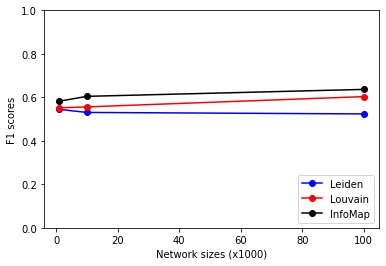

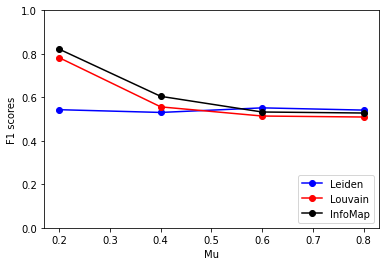

In [ ]:
x = [1, 10, 100]
plt.plot(x,ldn_random[:3], "bo-", label = "Leiden")
plt.plot(x, lvn_random[:3], "ro-", label = "Louvain")
plt.plot(x, imp_random[:3], color="black", marker="o", label = "InfoMap")
plt.xlabel("Network sizes (x1000)")
plt.ylabel("F1 scores")
plt.legend(loc="lower right")
plt.ylim(0, 1)
plt.show()

x = [0.2, 0.4, 0.6, 0.8]
plt.plot(x, [ldn_random[3], ldn_random[1], ldn_random[4], ldn_random[5]], "bo-", label = "Leiden")
plt.plot(x, [lvn_random[3], lvn_random[1], lvn_random[4], lvn_random[5]], "ro-", label = "Louvain")
plt.plot(x, [imp_random[3], imp_random[1], imp_random[4], imp_random[5]], color="black", marker="o", label = "InfoMap")
plt.ylim(0, 1)
plt.xlabel("Mu")
plt.ylabel("F1 scores")
plt.legend(loc="lower right")
plt.show()

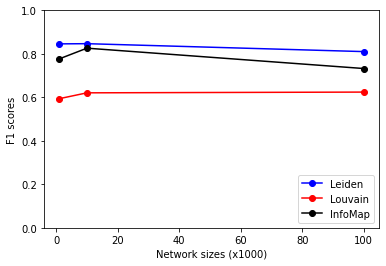

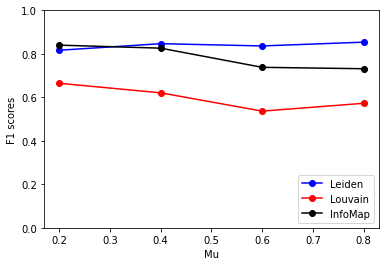

In [ ]:
x = [1, 10, 100]
plt.plot(x,ldn_replaced[:3], "bo-", label = "Leiden")
plt.plot(x, lvn_replaced[:3], "ro-", label = "Louvain")
plt.plot(x, imp_replaced[:3], color="black", marker="o", label = "InfoMap")
plt.ylim(0, 1)
plt.xlabel("Network sizes (x1000)")
plt.ylabel("F1 scores")
plt.legend(loc="lower right")
plt.show()


x = [0.2, 0.4, 0.6, 0.8]
plt.plot(x, [ldn_replaced[3], ldn_replaced[1], ldn_replaced[4], ldn_replaced[5]], "bo-", label = "Leiden")
plt.plot(x, [lvn_replaced[3], lvn_replaced[1], lvn_replaced[4], lvn_replaced[5]], "ro-", label = "Louvain")
plt.plot(x, [imp_replaced[3], imp_replaced[1], imp_replaced[4], imp_replaced[5]], color="black", marker="o", label = "InfoMap")
plt.ylim(0, 1)
plt.xlabel("Mu")
plt.ylabel("F1 scores")
plt.legend(loc="lower right")
plt.show()